## Nuclear Masses

In [1]:
import scipy.stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import read as rd
import emcee
from tqdm import tqdm
import corner


### Bayesian Inference

In [2]:
df = rd.read()
N = np.array(df["N"])
Z = np.array(df["Z"])
BE = np.array(df["binding"])*10**(-3)
BE_err = np.array(df["unc_binding"])*10**(-3)

In [3]:
def model(a_v,a_s,a_c,a_a,a_p,a_k,N,Z):
    A = N + Z
    #Coulomb can be Z*(Z-1) or Z**2
    ret = (a_v*A - a_s*A**(2/3) - a_c*Z*(Z-1)/(A**(1/3)) - a_a*((N-Z)**2)/A - a_k*A**(1/3))
    addend = (a_p*A**(-3/4))
    ret += np.logical_and((N%2 == 0), (Z%2 == 0)) * addend
    ret -= np.logical_and((N%2 == 1), (Z%2 == 1)) * addend
    return ret/A

## EMCEE

In [18]:
# Parameters
param_names = ['a_v', 'a_s', 'a_c', 'a_a', 'a_p', 'a_k']

def loglikelihood(params):
    (a_v, a_s, a_c, a_a, a_p, a_k) = params
    log_like = -np.sum(((model(a_v, a_s, a_c, a_a, a_p, a_k, N, Z) - BE)/BE_err)**2 + np.log(2*np.pi*BE_err**2)) / 2. 
    return log_like
    
def prior(params):
    (a_v, a_s, a_c, a_a, a_p, a_k) = params

    if (
        0 < a_v < 50 and
        0 < a_s < 50 and
        0 < a_c < 3 and
        0 < a_a < 40 and
        0 < a_p < 50 and
        0 < a_k < 10
    ):
        return 0

    return -np.inf

def log_post(params):
    if not np.isfinite(prior(params)):
        return -np.inf
    return loglikelihood(params) + prior(params)

In [19]:
ndim = 6
nwalkers = 36

p0 = np.array([0, 0, 0, 0, 0, 0]) + np.random.rand(nwalkers, ndim) * np.array(
    [50, 50, 3, 40, 50, 10]
)

In [20]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_post, args=())
sampler.run_mcmc(p0, 10000, progress=True)

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:40<00:00, 244.91it/s]


State([[1.23652596e+01 1.03290893e+01 2.91743575e-01 2.21104242e+01
  1.08026322e+01 1.79890897e-12]
 [1.23652595e+01 1.03290894e+01 2.91743554e-01 2.21104243e+01
  1.08026320e+01 9.52182217e-13]
 [1.23652600e+01 1.03290902e+01 2.91743619e-01 2.21104229e+01
  1.08026296e+01 8.47911461e-13]
 [1.23652593e+01 1.03290887e+01 2.91743515e-01 2.21104271e+01
  1.08026325e+01 1.06195480e-12]
 [1.23652605e+01 1.03290911e+01 2.91743705e-01 2.21104218e+01
  1.08026299e+01 1.97369204e-13]
 [1.23652601e+01 1.03290903e+01 2.91743661e-01 2.21104234e+01
  1.08026320e+01 3.31272597e-13]
 [1.23652595e+01 1.03290891e+01 2.91743530e-01 2.21104255e+01
  1.08026316e+01 2.64444718e-12]
 [1.23652591e+01 1.03290886e+01 2.91743487e-01 2.21104248e+01
  1.08026328e+01 8.77161380e-13]
 [1.23652595e+01 1.03290891e+01 2.91743544e-01 2.21104248e+01
  1.08026323e+01 1.44290927e-12]
 [1.23652595e+01 1.03290890e+01 2.91743538e-01 2.21104275e+01
  1.08026326e+01 2.34897976e-12]
 [1.23652594e+01 1.03290887e+01 2.91743553e-

Text(0.5, 0, 'step number')

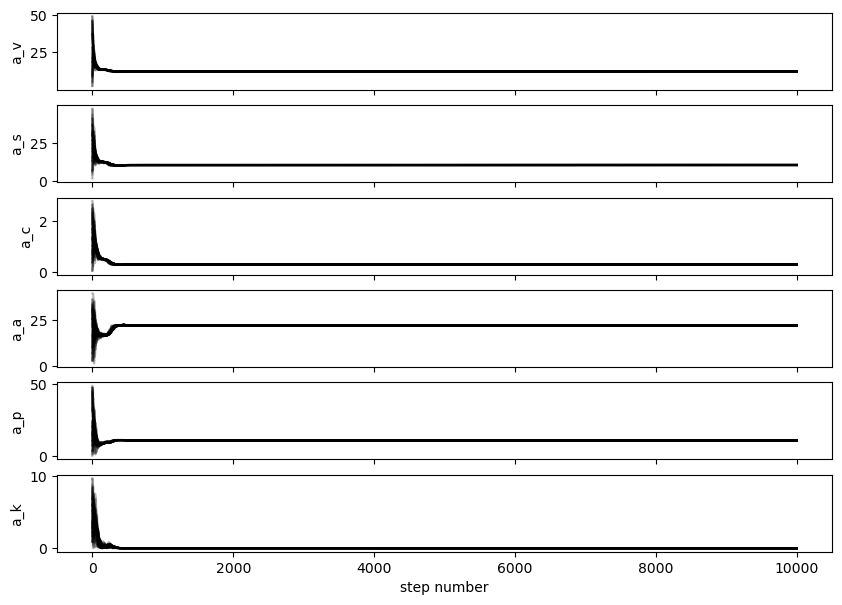

In [21]:
fig, axs = plt.subplots(6, 1, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

for index, ax in enumerate(axs):
    ax.plot(samples[:, :, index], "k", alpha=0.3)
    ax.set_ylabel(["a_v", "a_s", "a_c", "a_a", "a_p", "a_k"][index])

axs[-1].set_xlabel("step number")

Quantiles:
[(0.025, 12.36525902918753), (0.5, 12.36525978662101), (0.975, 12.365260540901495)]
Quantiles:
[(0.025, 10.329088256070344), (0.5, 10.329089672812618), (0.975, 10.329091088031284)]
Quantiles:
[(0.025, 0.29174347352247954), (0.5, 0.2917436064315372), (0.975, 0.2917437397375717)]
Quantiles:
[(0.025, 22.110421121508473), (0.5, 22.110424587537192), (0.975, 22.11042799027343)]
Quantiles:
[(0.025, 10.802629876718925), (0.5, 10.802631526855993), (0.975, 10.80263316458256)]
Quantiles:
[(0.025, 2.843203176864291e-14), (0.5, 7.697923108842032e-13), (0.975, 4.0655247103247175e-12)]


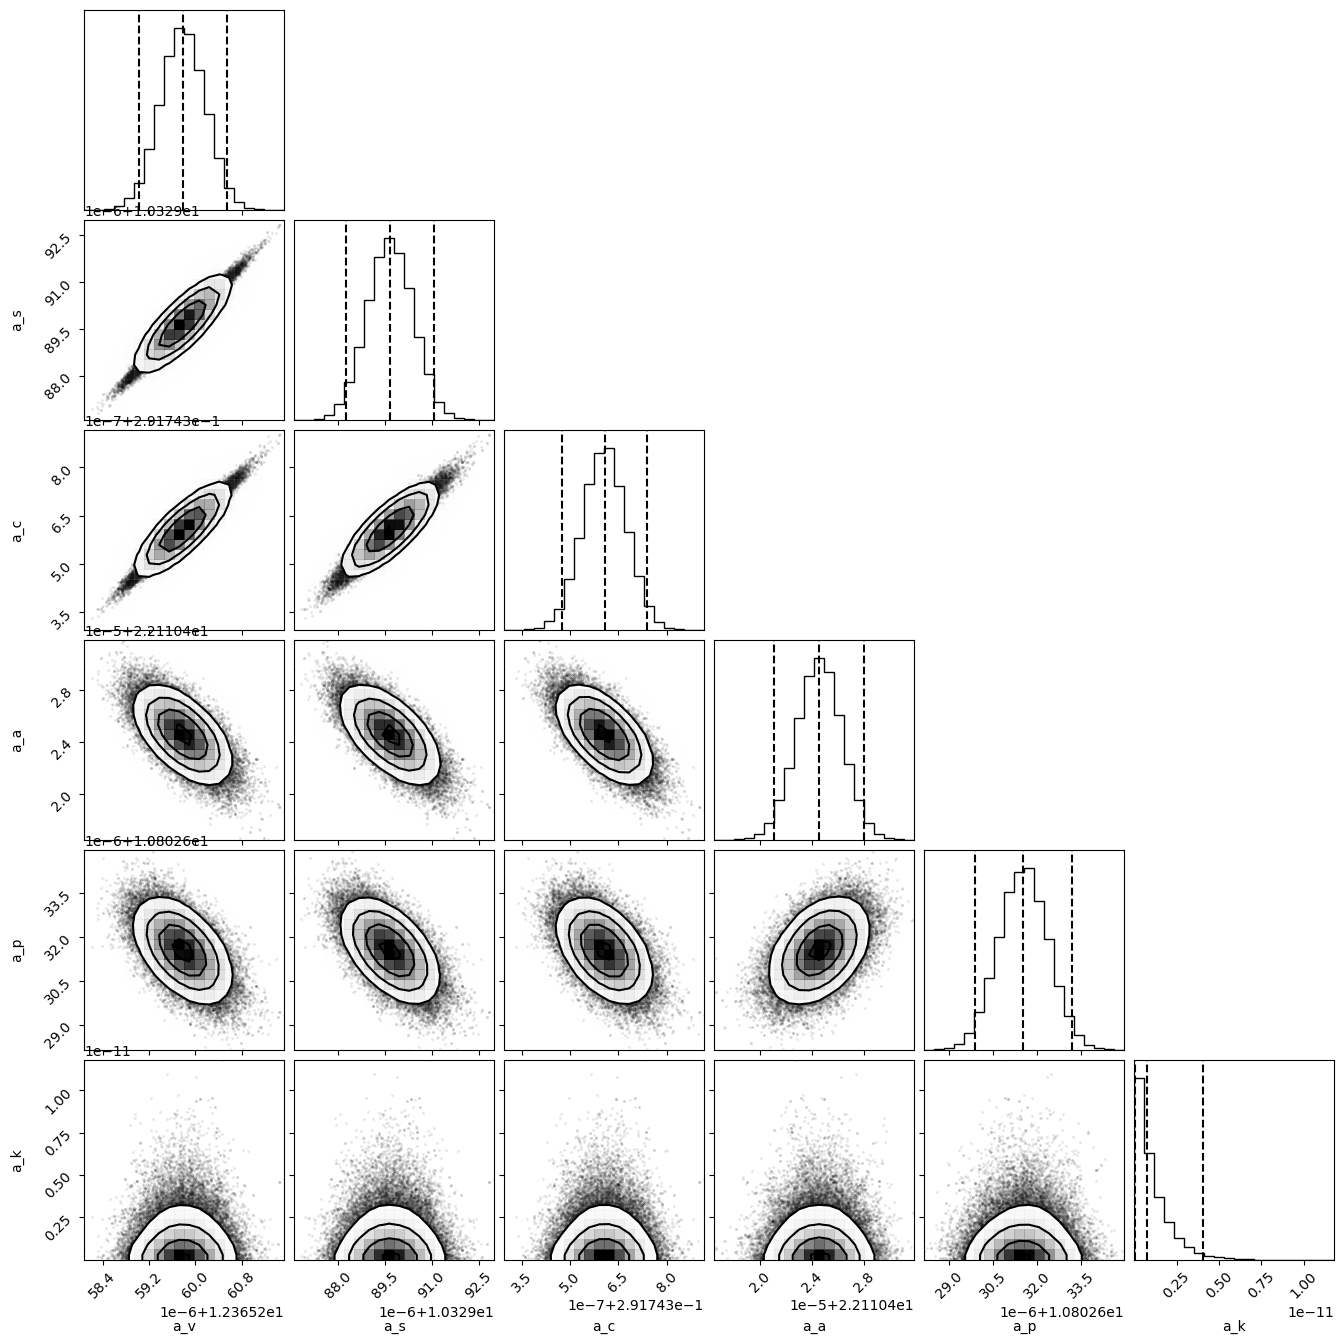

In [22]:
flat_samples = sampler.get_chain(discard=5000, thin=3, flat=True)
fig = corner.corner(flat_samples, labels=["a_v", "a_s", "a_c", "a_a", "a_p", "a_k"], verbose= True, plot_contours=True, quantiles=[0.025, 0.5, 0.975], smooth=True)

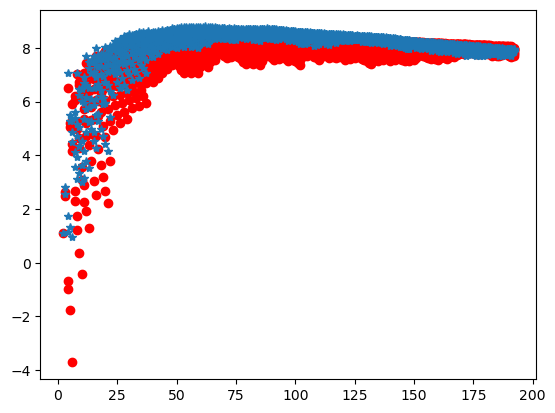

In [24]:
A = N + Z
n_points = 2000
plt.errorbar(A[:n_points], BE[:n_points], BE_err[:n_points], marker = "*" , ls = " ")

a_v_best = 12
a_s_best = 10
a_c_best = 0.3
a_a_best = 22
a_p_best = 10
a_k_best = 7e-13

BE_best = model(a_v_best, a_s_best, a_c_best, a_a_best, a_p_best, a_k_best,N, Z)
plt.scatter(A[:n_points], BE_best[:n_points], color = 'red')